BOOSTING Takip Algoritması:
    AdaBoost'un çevrimiçi bir sürümüne dayanmaktadır.
    Bu sınıflandırıcı, nesnenin olumlu ve olumsuz örnekleriyle çalışma zamanında eğitilmelidir.
    Kullanıcı (veya başka bir nesne algılama algoritması tarafından) tarafından sağlanan ilk sınırlayıcı kutu, nesne için olumlu bir örnek olarak alınır ve sınırlayıcı kutunun dışındaki birçok görüntü yaması arka plan olarak kabul edilir.
    Yeni bir çerçeve verildiğinde, sınıflandırıcı, önceki konumun çevresindeki her piksel üzerinde çalıştırılır ve sınıflandırıcının puanı kaydedilir.
    Nesnenin yeni konumu, puanın maksimum olduğu yerdir

In [1]:
#kutuphaneleri import edelim
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd


In [3]:
#kütüphanemiz sürümüne göre belli başlı takip uygulamalarını destekleyecektir

# Desteklenen takip algoritmalarını listele
algorithms = [key for key in dir(cv2) if key.startswith("Tracker")]

print("Desteklenen takip algoritmaları:")
for alg in algorithms:
    print(f"- {alg}")

Desteklenen takip algoritmaları:
- Tracker
- TrackerDaSiamRPN
- TrackerDaSiamRPN_Params
- TrackerDaSiamRPN_create
- TrackerGOTURN
- TrackerGOTURN_Params
- TrackerGOTURN_create
- TrackerMIL
- TrackerMIL_Params
- TrackerMIL_create
- TrackerNano
- TrackerNano_Params
- TrackerNano_create


Tracker: TrackerMIL
Tracking method:  < cv2.TrackerMIL 0000015854889C70>
Time:  13.773509740829468
Number of frame to track (gt):  451
Number of frame to track (track success):  113
Toplam hata:  55085.83922748765


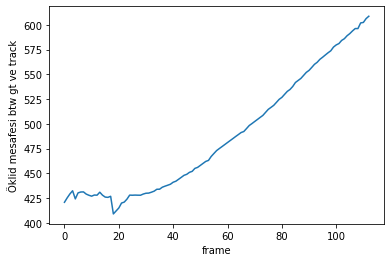

In [13]:
#desteklenen algoritmalarini yaziyotum
OPENCV_OBJECT_TRACKERS = {"TrackerDaSiamRPN": cv2.TrackerDaSiamRPN_create,
                          "TrackerGOTURN": cv2.TrackerGOTURN_create,
                          "TrackerMIL": cv2.TrackerMIL_create,
                          "TrackerNano": cv2.TrackerNano_create}

tracker_name = "TrackerMIL"  #desteklenen algoritmalardan digerlerini de deneyebilirsin
tracker = OPENCV_OBJECT_TRACKERS[tracker_name]()
print("Tracker:", tracker_name)

#gt_new.txt içerisindeki her bir famreye denk gelen bilgileri alıyoruz
gt = pd.read_csv("gt_new.txt")

#videomuzu iceri aktariyoruz
video_path = "MOT17-13-SDP.mp4"
#videoyu okuyoruz
cap = cv2.VideoCapture(video_path)

# genel parametreler
initBB = None #secmis olduğumuz nesneyi burada depolayacagiz
fps = 25
frame_number = [] 
f = 0
success_track_frame_success = 0 
track_list = []
start_time = time.time() #zamani baslatiyorum

while True:
    
    #yavaslatiyoruz
    time.sleep(0.01)
    
    #video oku
    ret, frame = cap.read()
    
    if ret:
        #yukseklik ve genizlik bilgilerini guncelle
        frame = cv2.resize(frame, dsize = (960,540))
        
        #yuksekligi ve genisligi aliyoruz
        (H, W) = frame.shape[:2]
        
        # gt alıyotuz
        car_gt = gt[gt.frame_no == f]
        
        #eger car_gt bos degilse
        if len(car_gt) != 0: 
            #kordinatlarini aliyoruz
            x = car_gt.x.values[0]
            y = car_gt.y.values[0]
            w = car_gt.w.values[0]
            h = car_gt.h.values[0]
            
            #merkezleri aliyoruz
            center_x = car_gt.center_x.values[0]
            center_y = car_gt.center_y.values[0]
            
            #kare icerisine aliyoruz               renk      kalinlik
            cv2.rectangle(frame, (x,y), (x+w, y+h),(0,255,0),2)
            
            #ortasina bir nokta ciziyoruz      kalinlik, renk, içi dolu
            cv2.circle(frame, (center_x, center_y), 2,(0,0,255),-1)
            
            
        # eger baslangic kutusu bos degilse
        if initBB is not None:
            
            #trackerimizi update ediyor olacagiz
            (success, box) = tracker.update(frame)
            
            
            
            if f<=np.max(gt.frame_no):
                
                (x,y,w,h) = [int(i) for i in box]
                
                #takip sonucunu görsellestiriyoruz
                    #kare içerisine aliyoruz()
                cv2.rectangle(frame, (x,y),(x+w,y+h),(0,0,255),2)
                
                #bir sonraki frame gec
                success_track_frame_success = success_track_frame_success + 1
                
                #x ve y ninortalarini bul
                track_center_x = int(x+w/2)
                track_center_y = int(y+h/2)
                #bu listeye ekle
                track_list.append([f,track_center_x,track_center_y])
            
            #temel sonuclarimiz yazacak 
            #tracker name ve basarili mi basarisiz mi 
            info = [("Tracker",tracker_name),
                    ("Success", "Yes" if success else "No")]
            
            # görüntü üzerine takip bilgilerini yazdırıyoruz
            for (i,(o,p)) in enumerate(info):
                text = "{}: {} ".format(o,p)
                cv2.putText(frame, text, (10, H -(i*20)-10), cv2.FONT_HERSHEY_SIMPLEX,0.6, (0,0,255),2)
                
        # görüntü üzerine frame numarasını yazdırıyoruz    
        cv2.putText(frame,"Frame Num: "+str(f), (10,30),cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,255),2)
        
        # Görüntüyü ekranda gösteriyoruz
        cv2.imshow("frame",frame)
        
        # klavyeden tuş girişi alıyoruz
        key = cv2.waitKey(1) & 0xFF
        
        #t ise cizim aciyoruz
        if key == ord("t"):
            #selectROI :takip etmek istedigimiz bolge anlamina gelir
            initBB = cv2.selectROI("Frame", frame, fromCenter = False)
            
            # seçilen bölgeyle tracker'ı başlatıyoruz
            tracker.init(frame, initBB)
        
        #q ise kapatiyoruz
        elif key == ord("q"):break
        
        
        # frame
        frame_number.append(f)
        f = f + 1 
        
    else: break
    
cap.release()
cv2.destroyAllWindows()            
            
stop_time = time.time()
time_diff = stop_time - start_time

# takip edilen verileri bir dataframe donusturuyoruz. içerisinde frame no, (x ve y) kordinatlarının ortasini barindiriyoruz
track_df = pd.DataFrame(track_list, columns =["frame_no","center_x","center_y"])

#eger veri bos degilse
if len(track_df) != 0:
    # takip yöntemini, zamanı, takip edilecek toplam frame sayısını ve başarılı takip edilen frame sayısını yazdırıyoruz
    print("Tracking method: ",tracker)
    print("Time: ",time_diff)#
    print("Number of frame to track (gt): ",len(gt))
    print("Number of frame to track (track success): ",success_track_frame_success)
    
    #takip edilen frame nolari
    track_df_frame = track_df.frame_no
    
    #gercek gt ile bizim gtmizi karsilastirmak için aliyoruz
    gt_center_x = gt.center_x[track_df_frame].values
    gt_center_y = gt.center_y[track_df_frame].values
    
    track_df_center_x = track_df.center_x.values
    track_df_center_y = track_df.center_y.values
    
    #matematiksel islem yaparak dogruluk buluyoruz
    plt.plot(np.sqrt((gt_center_x-track_df_center_x)**2 + (gt_center_y-track_df_center_y)**2 ))
    plt.xlabel("frame")
    plt.ylabel("Öklid mesafesi btw gt ve track")
    error = np.sum(np.sqrt((gt_center_x-track_df_center_x)**2 + (gt_center_y-track_df_center_y)**2 ))
    print("Toplam hata: ",error)






Kullanışı : t ile durdurup takip etmek istedigin classı secip bosluk tusuna basarsan o nesneyi de takip etmeye baslarsın